In [1]:
# !pip install matplotlib
# !pip install sklearn
# !pip install tqdm
# !pip install torch
# !pip install torchvision
# !pip install pandas
# !pip install transformers


In [2]:
!nvidia-smi

Sun May 29 14:47:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.05    Driver Version: 510.73.05    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   50C    P8     6W /  N/A |      5MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import json
import torch as t
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms.functional import to_tensor, normalize
import torchvision.transforms as transforms
import random
import torchvision.models as models
import os
from torchvision.transforms.functional import to_tensor
import pandas as pd

random_seed_run = int(np.random.rand() * 10000)
counter_dirs = 0
seed = 42
np.random.seed(seed)
np.random.RandomState(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(False)

EPOCHS = 20
NUM_LAYERS_FROZEN = 8
lr = 2e-4
DATASET_SIZE = 5000
multitask_lr = 2e-3
C_constant = 100
for base, dirs, files in os.walk("./reports/dino_carplate_cosineloss/"):
    for directory in dirs:
        counter_dirs += 1

data_saved_path = "./reports/dino_carplate_cosineloss/run" + str(counter_dirs) + '_' + str(random_seed_run)
model_save_path = "./models/dino_carplate_cosineloss/run" + str(counter_dirs) + '_'+ str(random_seed_run)
print(data_saved_path)

# current_model_path = 'model'
# save_path_model = os.path.join(data_saved_path, current_model_path)


./reports/dino_carplate_cosineloss/run0_8502


In [4]:
class RoadsignDataset(Dataset):
    def __init__(self, roadsign_root, roadsign_annot, roadsign_imgs, roadsign_temp, feature_extractor, img_size=(224, 224), dataset_size=-1, use_random_template=True, img_type="png"):
        """
        Args:
            dataset_lines (array): array of strings of form "{image_path}|{rectangle_coordinates}".
            width (int): target image width.
            height (int): target image height.
        """
        self.roadsign_root = roadsign_root
        self.roadsign_annot = roadsign_annot
        self.roadsign_imgs = roadsign_imgs
        self.feature_extractor = feature_extractor
        self.img_size = img_size
        self.use_random_template = use_random_template
        self.img_type = img_type
        self.dataset_size=dataset_size

        self.roadsign_annot_file = os.path.join(roadsign_root, roadsign_annot)
        self.roadsign_imgs_dir = os.path.join(roadsign_root, roadsign_imgs)
        self.roadsign_temp_dir = os.path.join(roadsign_root, roadsign_temp)

        with open(self.roadsign_annot_file) as infile:
            self.annot_data = json.load(infile)
        self.all_annot_types = self.annot_data['types']
        self.all_annotations = self.annot_data['imgs']

        self.init_dataset()

    def init_dataset(self):
        self.annotations_types = []
        for type in self.all_annot_types:
            full_path = os.path.join(self.roadsign_temp_dir, type + "." + self.img_type)
            if os.path.exists(full_path):
                self.annotations_types.append(type)
        print(self.annotations_types)
        self.annotations_to_id = {ann: idx for idx, ann in enumerate(self.annotations_types)}
        self.id_to_annotations = {idx: ann for ann, idx in self.annotations_to_id.items()}
        print(self.annotations_to_id)
        self.annotations = {}
        current_id = 0
        for key, item in self.all_annotations.items():
            annot_list = [data['category'] for data in item['objects']]
            if len(annot_list) != len(set(annot_list)):
                continue
            for annot_data in item['objects']:
                if annot_data['category'] in self.annotations_types:
                    self.annotations[current_id] = {
                        'path': item['path'].split("/")[1],
                        'id': current_id,
                        'object': annot_data
                    }
                    current_id += 1
                    break
        print(len(self.annotations))
        with open(os.path.join(self.roadsign_root, 'new_' + self.roadsign_annot), 'w') as outfile:
            json.dump({
                'types': self.annotations_types,
                'imgs': self.annotations
            }, outfile)
        if self.dataset_size == -1:
            limit_size = self.annotations
            self.dataset_size = len(self.annotations)
        else:
            limit_size = {key: item for key, item in self.annotations.items() if key < self.dataset_size}
        self.annotations = limit_size

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        ok = True
        data = self.annotations[idx]
        img_path = os.path.join(self.roadsign_imgs_dir, data['path'])

        use_other_template = np.random.rand()
        annotation = data['object']
        template_used = annotation['category']
        if use_other_template > 0.5 and self.use_random_template:
            use_other_template = 1
            new_id = np.random.randint(len(self.annotations_types))
            while self.annotations_to_id[template_used] == new_id:
                new_id = np.random.randint(len(self.annotations_types))
            template_used = self.id_to_annotations[new_id]

        annotation_id = self.annotations_to_id[template_used]
        template_path = os.path.join(self.roadsign_temp_dir, template_used + "." + self.img_type)

        img = Image.open(img_path)
        temp = Image.open(template_path)
        if temp.mode == 'RGBA':
            temp = temp.convert('RGB')


        original_width, original_height = img.size
        similarity = -1 if use_other_template == 1 else 1

        img = img.resize(self.img_size)
        img = np.array(img)
        temp = temp.resize(self.img_size)
        temp = np.array(temp)

        # if len(img.shape) == 2:
        #   img = np.expand_dims(img, axis=2)
        #   img = np.repeat(img, 3, axis=2)
        # if len(temp.shape) == 2:
        #   temp = np.expand_dims(temp, axis=2)
        #   temp = np.repeat(temp, 3, axis=2)

        img = to_tensor(img)
        temp = to_tensor(temp)

        # temp = to_tensor(temp)
        # transform = transforms.Compose([
        #     transforms.RandomHorizontalFlip(),
        #     transforms.RandomVerticalFlip()
        #     # transforms.ToTensor()
        # ])
        # if random.random() < 0.5:
        # img = transform(img)
        # else:
        #     img = to_tensor(img)



        bbox = annotation['bbox']

        xmin = bbox['xmin']
        xmax = bbox['xmax']
        ymin = bbox['ymin']
        ymax = bbox['ymax']

        # x1 = x1 / original_width * self.img_size[0]
        # x2 = x2 / original_width * self.img_size[0]
        # y1 = y1 / original_height * self.img_size[1]
        # y2 = y2 / original_height * self.img_size[1]
        xmin = xmin / original_width
        xmax = xmax / original_width
        ymin = ymin / original_height
        ymax = ymax / original_height

        coordinates = np.array([xmin, ymin, xmax, ymax])
        coordinates = coordinates.astype(np.float32)

        if ok == False:
            processed_imgs = self.feature_extractor(img, return_tensors='pt')
            processed_temps = self.feature_extractor(temp, return_tensors='pt')

            return np.array(processed_imgs['pixel_values']).squeeze(), np.array(processed_temps['pixel_values']).squeeze(), similarity, coordinates
        return img, temp, similarity, coordinates



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


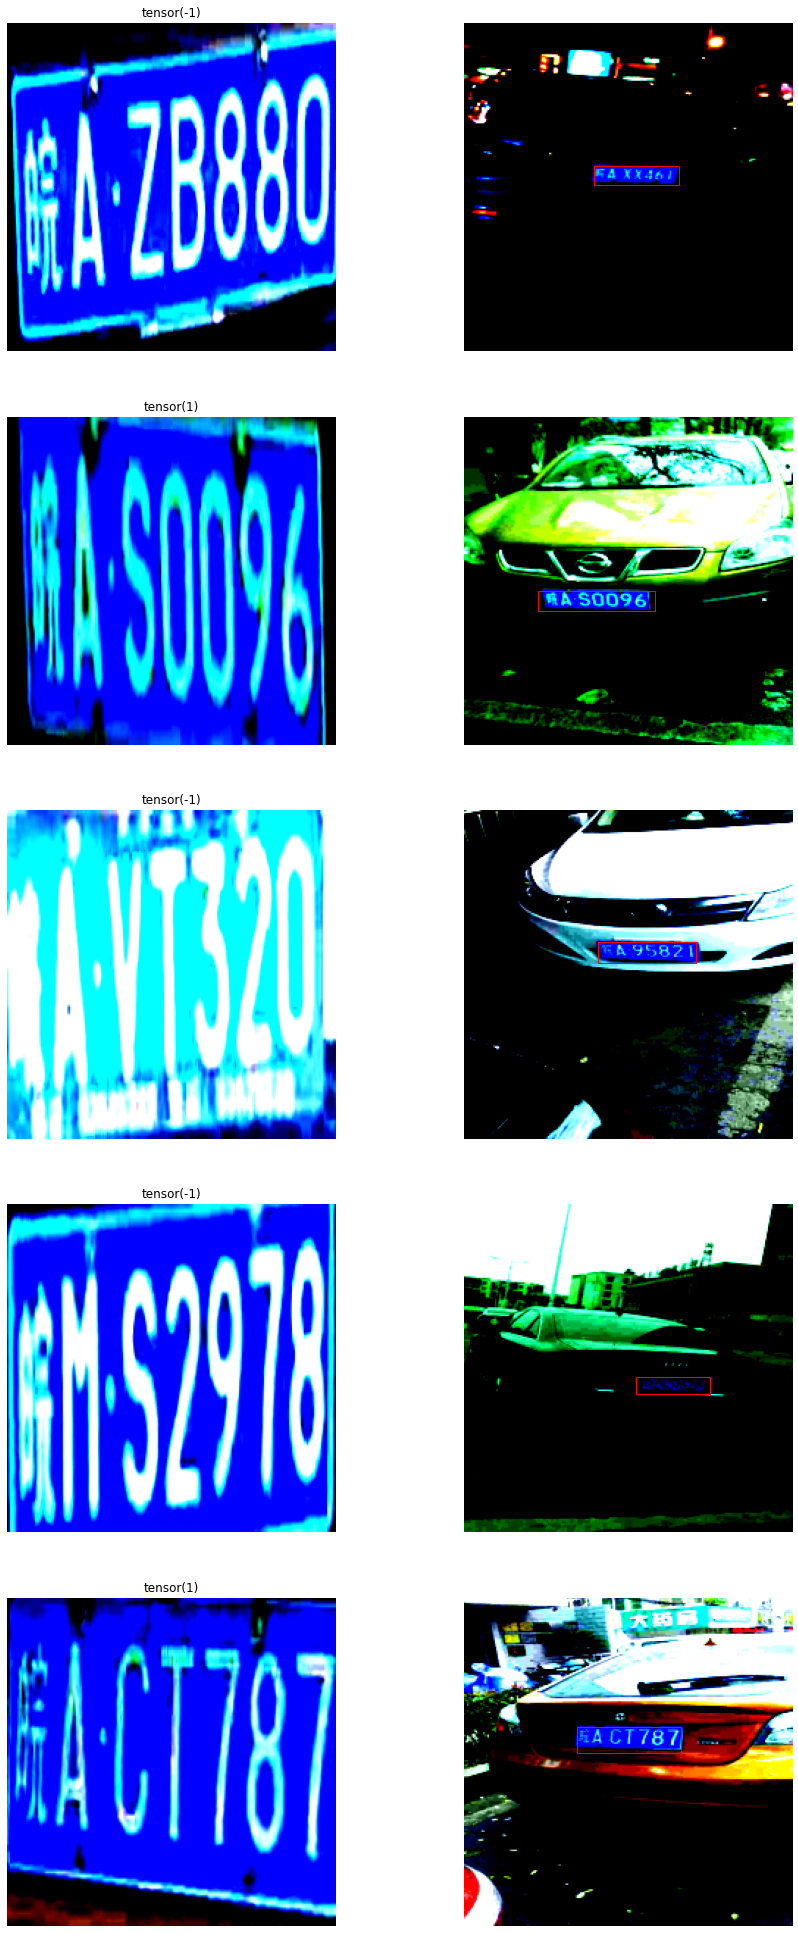

In [5]:
from IPython.display import clear_output
import time
from transformers import ViTFeatureExtractor

feature_extractor = ViTFeatureExtractor.from_pretrained('facebook/dino-vitb16')

carplate_root = "./data/data-carplate"
carplate_anno = "annotations.json"

batch_train = 8
batch_valid = 1

dataset = CarPlateDataset(carplate_root, carplate_anno, feature_extractor, dataset_size=DATASET_SIZE, use_random_template=True, img_size=(224, 224))
DATASET_SIZE = dataset.dataset_size
train_size = int(DATASET_SIZE * 0.8)
valid_size = DATASET_SIZE - train_size
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])
train_dataloader = DataLoader(train_dataset, batch_size=batch_train, shuffle=True, num_workers=4)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_valid, shuffle=False, num_workers=4)

see_examples = 5
fig = plt.figure(figsize=(15, 7*see_examples))
for i, (imgs, temp, similarity, coordinates) in enumerate(train_dataloader):
    clear_output(wait=True)
    imgs = np.transpose(imgs, (0, 2, 3, 1))
    temp = np.transpose(temp, (0, 2, 3, 1))
    fig.add_subplot(see_examples, 2, i * 2 + 1)
    plt.title(similarity[0])
    plt.axis('off')
    plt.imshow(temp[0])
   
    fig.add_subplot(see_examples, 2, i * 2 + 2)
    
    plt.axis('off')
    plt.imshow(imgs[0])

    x1, y1, x2, y2 = coordinates[0]
    x1 = x1 * dataset.img_size[1]
    y1 = y1 * dataset.img_size[0]
    x2 = x2 * dataset.img_size[1]
    y2 = y2 * dataset.img_size[0]

    rect = patches.Rectangle((x1,y1),x2-x1+1,y2-y1+1,linewidth=1,edgecolor='r',facecolor='none')
    plt.gca().add_patch(rect)
    

    if i >= see_examples - 1:
      break
plt.show()


In [6]:
from transformers import ViTForImageClassification, ViTConfig, ViTModel

# vit_config = ViTConfig(hidden_dropout_prob=0.5, attention_probs_dropout_prob=0.5)

# vit_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
#                                                       num_labels=len(category2id),
#                                                       id2label=id2category,
#                                                       label2id=category2id)
vit_backbone_image = ViTModel.from_pretrained('facebook/dino-vitb16')
# vit_backbone_template = ViTModel.from_pretrained('google/vit-base-patch16-384')

for param in vit_backbone_image.embeddings.parameters():
    param.requires_grad = False
for layer in vit_backbone_image.encoder.layer[:NUM_LAYERS_FROZEN]:
    print(layer)
    for param in layer.parameters():
        param.requires_grad = False
        
# for param in vit_backbone_template.embeddings.parameters():
#     param.requires_grad = False
# for layer in vit_backbone_template.encoder.layer[:NUM_LAYERS_FROZEN]:
#     print(layer)
#     for param in layer.parameters():
#         param.requires_grad = False

# print(vit_model)
# print(vars(vit_backbone))

class SiameseTransformerViT(nn.Module):
    def __init__(self, backbone_image):
        super(SiameseTransformerViT, self).__init__()
        self.backbone_image = backbone_image
        # self.backbone_template = backbone_template
    
        self.bounding_box = nn.Sequential(
            nn.Linear(backbone_image.config.hidden_size * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 4),
        )

        self.linear_layer_image = nn.Linear(backbone_image.config.hidden_size, backbone_image.config.hidden_size)
        self.linear_layer_template = nn.Linear(backbone_image.config.hidden_size, backbone_image.config.hidden_size)
    def forward_once(self, x):
        x = self.backbone_image(x)
        x = x.last_hidden_state[:, 0, :]
        return x
        

    def forward(self, image, template):
        image_features = self.forward_once(image)
        template_features = self.forward_once(template)
        image_features = self.linear_layer_image(image_features)
        template_features = self.linear_layer_template(template_features)
        similarity = nn.functional.cosine_similarity(image_features, template_features)
        bbox_prediction = self.bounding_box(torch.cat([image_features, template_features], 1))
        # features = features.last_hidden_state[:, 0, :]
        # print(features[:, 0, :].shape)
        return image_features, template_features, similarity, bbox_prediction


class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, feature_first, feature_second, label):
        euclidean_distance = nn.functional.pairwise_distance(feature_first, feature_second, keepdim=True)

        # print(torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2), euclidean_distance, label)
        label[label == -1] = 0
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        # label[label == 0] = -1
        # if label == 1:
        #     loss_contrastive = torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        # else:
        #     loss_contrastive = torch.pow(euclidean_distance, 2)

        return torch.mean(loss_contrastive)

vit_model = SiameseTransformerViT(vit_backbone_image)


Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTLayer(
  (attention): ViTAttention(
    (attention): ViTSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (output): ViTSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
  )
  (intermediate): ViTIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): ViTOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
)
ViTLayer(
  (attention): ViTAttention(
    (attention): ViTSelfAttention(
 

In [7]:
def calculate_iou_acc(iou_list, counter):
    iou_list_50 = (iou_list > 0.5).sum()
    iou_list_75 = (iou_list > 0.75).sum()
    iou_list_90 = (iou_list > 0.90).sum()
    return [iou_list_50 / counter, iou_list_75 / counter, iou_list_90 / counter]

def bb_intersection_over_union(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

def train_epoch(model, train_dataloader, loss_bounding_box, loss_contrastive, optimizer, device, C=1):
    model.train()
    total_data = 0
    similarity_acc = 0.0
    epoch_loss = 0.0
    num_batches = len(train_dataloader)
    predictions = []
    IOU_list = []
    labels = []
    images = []
    templates = []
    similarity_data = []
    similarity_predicted_data = []
    for idx, batch in tqdm(enumerate(train_dataloader)):
        batch_images, batch_templates, batch_similarities, batch_bboxs = batch
        batch_images = batch_images.to(device)
        batch_templates = batch_templates.to(device)
        batch_similarities = batch_similarities.to(device)
        batch_bboxs = batch_bboxs.to(device)

        image_features, template_features, predicted_similarities, predicted_bboxs = model(batch_images, batch_templates)

        # nullify the bbox if the template is wrong
        # for index in range(len(batch_bboxs)):
        #     if batch_similarities[index] == -1:
        #         predicted_bboxs[index] = batch_bboxs[index]
        #         # predicted_bboxs[index].detach()
        # print(predicted_bboxs)
        # print(batch_bboxs)
        # print(batch_similarities)
        loss_bbox = loss_bounding_box(predicted_bboxs, batch_bboxs)
        loss_contr = loss_contrastive(image_features, template_features, batch_similarities)

        loss = loss_bbox + loss_contr / C

        # print(loss_bbox, loss_contr)
        # if loss_contr > 0:
        #     print(loss_bbox, loss_contr)
        loss_scalar = loss.item()

        # if idx % 150 == 0:
        #     print(epoch_acc/(idx + 1))
        #     print(batch_predictions)

        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=1.5
        )

        model.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss_scalar
        modified_predicted_similarities = torch.round(predicted_similarities.detach().cpu()).int()
        modified_predicted_similarities[modified_predicted_similarities == 0] = -1
        # print(modified_predicted_similarities, batch_similarities)
        similarity_acc += torch.sum(batch_similarities.detach().cpu() == modified_predicted_similarities)
        total_data += len(batch_similarities)
        
        bbox_pred = predicted_bboxs.detach().cpu().numpy()
        bbox_original = batch_bboxs.cpu().numpy()

        images.append(batch_images[0].detach().cpu())
        templates.append(batch_templates[0].detach().cpu())
        labels.append(bbox_original[0])
        predictions.append(bbox_pred[0])
        similarity_data.append(batch_similarities[0].detach().cpu())
        similarity_predicted_data.append(predicted_similarities[0].detach().cpu())
        IOU_list.append(bb_intersection_over_union(bbox_pred[0], bbox_original[0]))

    all_data = {
        'images': images,
        'templates': templates,
        'labels': labels,
        'predictions': predictions,
        'similarity': similarity_data,
        'similarity_predicted': similarity_predicted_data
    }
    epoch_loss = epoch_loss/num_batches
    similarity_acc = similarity_acc / total_data
    similarity_acc = similarity_acc.detach().cpu()
    IOU_list = np.array(IOU_list)

    return epoch_loss, IOU_list, labels, predictions, similarity_acc, all_data


def eval_epoch(model, val_dataloader, loss_bounding_box, loss_contrastive, device,C=1):
    model.eval()
    epoch_loss = 0.0
    total_data = 0
    similarity_acc = 0.0
    num_batches = len(val_dataloader)
    IOU_list = []
    predictions = []
    images = []
    templates = []
    labels = []
    similarity_data = []
    similarity_predicted_data = []
    with torch.no_grad():
        for idx, batch in tqdm(enumerate(val_dataloader)):
            batch_images, batch_templates, batch_similarities, batch_bboxs = batch
            batch_images = batch_images.to(device)
            batch_templates = batch_templates.to(device)
            batch_similarities = batch_similarities.to(device)
            batch_bboxs = batch_bboxs.to(device)

            image_features, template_features, predicted_similarities, predicted_bboxs = model(batch_images, batch_templates)

            # for index in range(len(batch_bboxs)):
            #     if batch_similarities[index] == -1:
            #         predicted_bboxs[index] = batch_bboxs[index]

            loss_bbox = loss_bounding_box(predicted_bboxs, batch_bboxs)
            loss_contr = loss_contrastive(image_features, template_features, batch_similarities)

            loss = loss_bbox + loss_contr / C

            loss_scalar = loss.item()

            epoch_loss += loss_scalar
            modified_predicted_similarities = torch.round(predicted_similarities.detach().cpu()).int()
            modified_predicted_similarities[modified_predicted_similarities == 0] = -1
            similarity_acc += torch.sum(batch_similarities.detach().cpu() == modified_predicted_similarities)
            total_data += len(batch_similarities)

            bbox_pred = predicted_bboxs.detach().cpu().numpy()
            bbox_original = batch_bboxs.detach().cpu().numpy()
            images.append(batch_images[0].detach().cpu())
            templates.append(batch_templates[0].detach().cpu())
            labels.append(bbox_original[0])
            predictions.append(bbox_pred[0])
            similarity_data.append(batch_similarities[0].detach().cpu())
            similarity_predicted_data.append(predicted_similarities[0].detach().cpu())

            IOU_list.append(bb_intersection_over_union(bbox_pred[0], bbox_original[0]))

        epoch_loss = epoch_loss/num_batches
        similarity_acc = similarity_acc / total_data
        similarity_acc = similarity_acc.detach().cpu()
        IOU_list = np.array(IOU_list)
        all_data = {
            'images': images,
            'templates': templates,
            'labels': labels,
            'predictions': predictions
        }

    return epoch_loss, IOU_list, labels, predictions, similarity_acc, all_data



In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# move the model to GPU (when available)
vit_model.to(device)

# create a SGD optimizer
optimizer = torch.optim.AdamW(vit_model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(vit_model.parameters(), lr=1e-3, momentum=0.9)
# optimizer = torch.optim.Adam(vit_model.parameters(), lr=2e-5)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, threshold=1e-2, verbose=True)
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
#
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, threshold=1e-3, verbose=True)

# set up loss function
loss_function_bbox = nn.MSELoss()
loss_function_contrastive = nn.CosineEmbeddingLoss()
# loss_function_contrastive = nn.CosineEmbeddingLoss(margin=0.5)


train_losses = []
train_accuracies = []
train_iou = []
val_losses = []
val_accuracies = []
val_iou =[]
for epoch in range(1, EPOCHS+1):
    train_loss, train_IOU_data, train_bboxes, train_predicted_bboxes, train_similarity_acc, train_all_data = train_epoch(vit_model, train_dataloader, loss_function_bbox, loss_function_contrastive, optimizer, device, C=C_constant)
    val_loss, val_IOU_data, val_bboxes, val_predicted_bboxes, val_similarity_acc, val_all_data = eval_epoch(vit_model, valid_dataloader, loss_function_bbox, loss_function_contrastive, device, C=C_constant)
    train_IOU_data = calculate_iou_acc(train_IOU_data, len(train_dataloader))
    val_IOU_data = calculate_iou_acc(val_IOU_data, len(valid_dataloader))
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_similarity_acc)
    val_accuracies.append(val_similarity_acc)
    train_iou.append(train_IOU_data)
    val_iou.append(val_IOU_data)
    print('\nEpoch %d'%(epoch))
    print('train loss: %10.8f, accuracy: %10.8f'%(train_loss, train_similarity_acc))
    print(f"train IOU 50% accuracy: {train_IOU_data[0]}")
    print(f"train IOU 75% accuracy: {train_IOU_data[1]}")
    print(f"train IOU 90% accuracy: {train_IOU_data[2]}")
    print('val loss: %10.8f, accuracy: %10.8f'%(val_loss, val_similarity_acc))
    print(f"val IOU 50% accuracy: {val_IOU_data[0]}")
    print(f"val IOU 75% accuracy: {val_IOU_data[1]}")
    print(f"val IOU 90% accuracy: {val_IOU_data[2]}")


cuda


500it [01:57,  4.24it/s]
1000it [00:27, 35.82it/s]


Epoch 1
train loss: 0.02795012, accuracy: 0.49200001
train IOU 50% accuracy: 0.962
train IOU 75% accuracy: 0.636
train IOU 90% accuracy: 0.068
val loss: 0.01259413, accuracy: 0.47200000
val IOU 50% accuracy: 1.0
val IOU 75% accuracy: 0.759
val IOU 90% accuracy: 0.053



500it [01:57,  4.24it/s]
1000it [00:28, 35.27it/s]


Epoch 2
train loss: 0.01219432, accuracy: 0.50075001
train IOU 50% accuracy: 1.0
train IOU 75% accuracy: 0.81
train IOU 90% accuracy: 0.132
val loss: 0.00835910, accuracy: 0.50199997
val IOU 50% accuracy: 1.0
val IOU 75% accuracy: 0.944
val IOU 90% accuracy: 0.371



500it [01:58,  4.23it/s]
1000it [00:31, 31.76it/s]


Epoch 3
train loss: 0.00990329, accuracy: 0.49375001
train IOU 50% accuracy: 1.0
train IOU 75% accuracy: 0.876
train IOU 90% accuracy: 0.204
val loss: 0.00778419, accuracy: 0.49900001
val IOU 50% accuracy: 1.0
val IOU 75% accuracy: 0.987
val IOU 90% accuracy: 0.403



500it [01:57,  4.24it/s]
1000it [00:27, 35.96it/s]



Epoch 4
train loss: 0.00837911, accuracy: 0.51599997
train IOU 50% accuracy: 1.0
train IOU 75% accuracy: 0.918
train IOU 90% accuracy: 0.356
val loss: 0.00672858, accuracy: 0.47099999
val IOU 50% accuracy: 1.0
val IOU 75% accuracy: 0.996
val IOU 90% accuracy: 0.584


500it [01:57,  4.24it/s]
1000it [00:27, 36.40it/s]


Epoch 5
train loss: 0.00770840, accuracy: 0.52450001
train IOU 50% accuracy: 1.0
train IOU 75% accuracy: 0.942
train IOU 90% accuracy: 0.398
val loss: 0.00798642, accuracy: 0.53399998
val IOU 50% accuracy: 1.0
val IOU 75% accuracy: 0.964
val IOU 90% accuracy: 0.15



500it [01:57,  4.24it/s]
1000it [00:27, 35.82it/s]


Epoch 6
train loss: 0.00687840, accuracy: 0.67774999
train IOU 50% accuracy: 1.0
train IOU 75% accuracy: 0.948
train IOU 90% accuracy: 0.426
val loss: 0.00536057, accuracy: 0.79100001
val IOU 50% accuracy: 1.0
val IOU 75% accuracy: 0.982
val IOU 90% accuracy: 0.547



500it [01:57,  4.24it/s]
1000it [00:27, 36.16it/s]


Epoch 7
train loss: 0.00586948, accuracy: 0.76924998
train IOU 50% accuracy: 1.0
train IOU 75% accuracy: 0.966
train IOU 90% accuracy: 0.46
val loss: 0.00402720, accuracy: 0.81099999
val IOU 50% accuracy: 1.0
val IOU 75% accuracy: 0.997
val IOU 90% accuracy: 0.733



500it [01:57,  4.24it/s]
1000it [00:27, 36.55it/s]


Epoch 8
train loss: 0.00526218, accuracy: 0.79974997
train IOU 50% accuracy: 1.0
train IOU 75% accuracy: 0.962
train IOU 90% accuracy: 0.454
val loss: 0.00456988, accuracy: 0.78200001
val IOU 50% accuracy: 1.0
val IOU 75% accuracy: 0.989
val IOU 90% accuracy: 0.559



500it [01:58,  4.23it/s]
1000it [00:27, 36.25it/s]


Epoch 9
train loss: 0.00527956, accuracy: 0.78549999
train IOU 50% accuracy: 1.0
train IOU 75% accuracy: 0.966
train IOU 90% accuracy: 0.448
val loss: 0.00357148, accuracy: 0.80000001
val IOU 50% accuracy: 1.0
val IOU 75% accuracy: 1.0
val IOU 90% accuracy: 0.715



500it [01:57,  4.24it/s]
1000it [00:27, 36.31it/s]


Epoch 10
train loss: 0.00492315, accuracy: 0.78399998
train IOU 50% accuracy: 0.998
train IOU 75% accuracy: 0.974
train IOU 90% accuracy: 0.476
val loss: 0.00350571, accuracy: 0.78100002
val IOU 50% accuracy: 1.0
val IOU 75% accuracy: 1.0
val IOU 90% accuracy: 0.759



500it [01:57,  4.24it/s]
1000it [00:27, 36.31it/s]


Epoch 11
train loss: 0.00461096, accuracy: 0.79549998
train IOU 50% accuracy: 1.0
train IOU 75% accuracy: 0.976
train IOU 90% accuracy: 0.532
val loss: 0.00337415, accuracy: 0.80400002
val IOU 50% accuracy: 1.0
val IOU 75% accuracy: 1.0
val IOU 90% accuracy: 0.803



500it [01:57,  4.24it/s]
1000it [00:27, 35.89it/s]


Epoch 12
train loss: 0.00432968, accuracy: 0.80250001
train IOU 50% accuracy: 1.0
train IOU 75% accuracy: 0.994
train IOU 90% accuracy: 0.544
val loss: 0.00390586, accuracy: 0.79500002
val IOU 50% accuracy: 1.0
val IOU 75% accuracy: 0.999
val IOU 90% accuracy: 0.65



500it [01:57,  4.24it/s]
1000it [00:27, 36.24it/s]


Epoch 13
train loss: 0.00424564, accuracy: 0.80675000
train IOU 50% accuracy: 1.0
train IOU 75% accuracy: 0.988
train IOU 90% accuracy: 0.558
val loss: 0.00309117, accuracy: 0.80599999
val IOU 50% accuracy: 1.0
val IOU 75% accuracy: 1.0
val IOU 90% accuracy: 0.899



500it [01:57,  4.24it/s]
1000it [00:27, 36.49it/s]


Epoch 14
train loss: 0.00414609, accuracy: 0.80475003
train IOU 50% accuracy: 1.0
train IOU 75% accuracy: 0.976
train IOU 90% accuracy: 0.55
val loss: 0.00308478, accuracy: 0.81099999
val IOU 50% accuracy: 1.0
val IOU 75% accuracy: 1.0
val IOU 90% accuracy: 0.83



500it [01:58,  4.24it/s]
1000it [00:27, 36.35it/s]


Epoch 15
train loss: 0.00401759, accuracy: 0.80100000
train IOU 50% accuracy: 1.0
train IOU 75% accuracy: 0.988
train IOU 90% accuracy: 0.576
val loss: 0.00356295, accuracy: 0.77700001
val IOU 50% accuracy: 1.0
val IOU 75% accuracy: 1.0
val IOU 90% accuracy: 0.73



500it [01:58,  4.23it/s]
1000it [00:28, 35.66it/s]


Epoch 16
train loss: 0.00379715, accuracy: 0.81075001
train IOU 50% accuracy: 1.0
train IOU 75% accuracy: 0.984
train IOU 90% accuracy: 0.616
val loss: 0.00306472, accuracy: 0.79799998
val IOU 50% accuracy: 1.0
val IOU 75% accuracy: 1.0
val IOU 90% accuracy: 0.916



500it [01:57,  4.24it/s]
1000it [00:27, 35.98it/s]


Epoch 17
train loss: 0.00370114, accuracy: 0.81050003
train IOU 50% accuracy: 1.0
train IOU 75% accuracy: 0.992
train IOU 90% accuracy: 0.636
val loss: 0.00295993, accuracy: 0.79900002
val IOU 50% accuracy: 1.0
val IOU 75% accuracy: 1.0
val IOU 90% accuracy: 0.931



500it [01:57,  4.24it/s]
1000it [00:27, 36.42it/s]


Epoch 18
train loss: 0.00365214, accuracy: 0.81000000
train IOU 50% accuracy: 1.0
train IOU 75% accuracy: 0.988
train IOU 90% accuracy: 0.676
val loss: 0.00283723, accuracy: 0.82300001
val IOU 50% accuracy: 1.0
val IOU 75% accuracy: 0.999
val IOU 90% accuracy: 0.881



500it [01:57,  4.24it/s]
1000it [00:28, 35.22it/s]


Epoch 19
train loss: 0.00343000, accuracy: 0.83125001
train IOU 50% accuracy: 1.0
train IOU 75% accuracy: 0.998
train IOU 90% accuracy: 0.646
val loss: 0.00293654, accuracy: 0.80599999
val IOU 50% accuracy: 1.0
val IOU 75% accuracy: 1.0
val IOU 90% accuracy: 0.914



500it [01:58,  4.23it/s]
1000it [00:27, 35.98it/s]


Epoch 20
train loss: 0.00336998, accuracy: 0.83225000
train IOU 50% accuracy: 1.0
train IOU 75% accuracy: 0.998
train IOU 90% accuracy: 0.65
val loss: 0.00285997, accuracy: 0.82200003
val IOU 50% accuracy: 1.0
val IOU 75% accuracy: 1.0
val IOU 90% accuracy: 0.845


In [9]:
try:
    os.makedirs(data_saved_path)
    os.makedirs(model_save_path)
except:
    print("Directory already exists")


In [10]:
# save model
torch.save(vit_model.state_dict(), os.path.join(model_save_path, "base_model_weights.pt"))


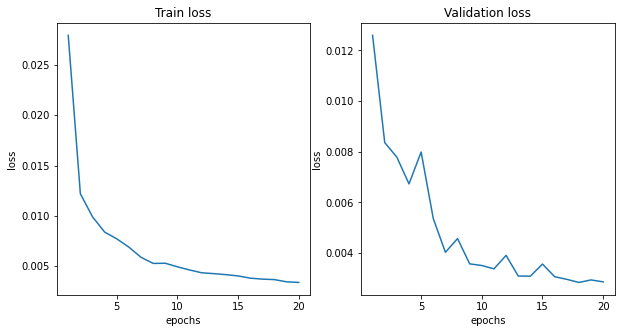

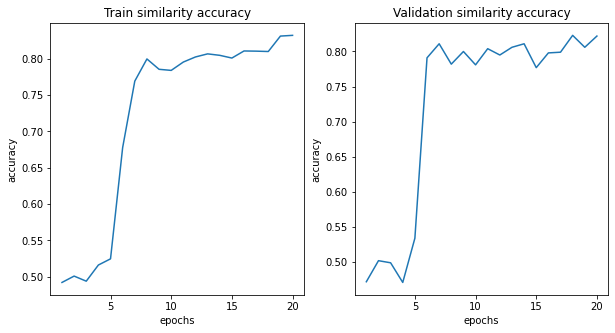

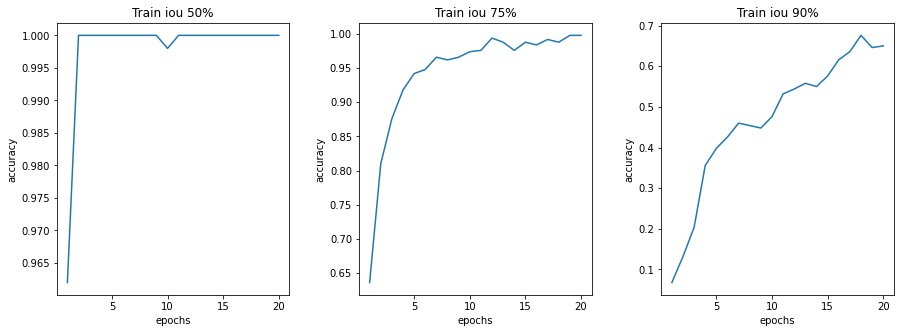

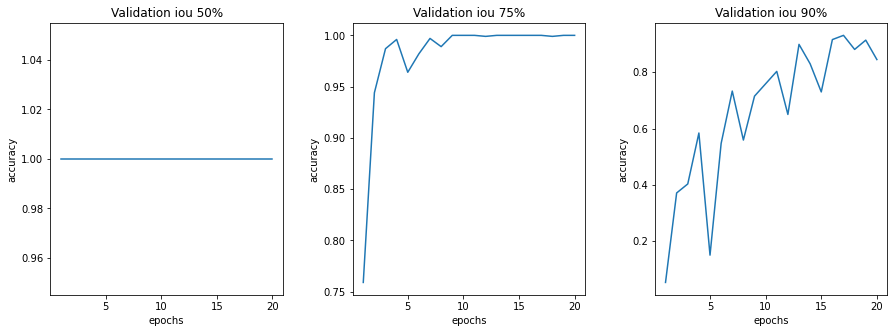

In [11]:
# train plots
epoch_list = np.arange(1, EPOCHS + 1, 1)
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(epoch_list, train_losses)
axs[0].set_title('Train loss')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('loss')
axs[1].plot(epoch_list, val_losses)
axs[1].set_title('Validation loss')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('loss')
plt.subplots_adjust(wspace=0.2)
plt.savefig(os.path.join(data_saved_path, 'loss_plots.png'))
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(epoch_list, train_accuracies)
axs[0].set_title('Train similarity accuracy')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('accuracy')
axs[1].plot(epoch_list, val_accuracies)
axs[1].set_title('Validation similarity accuracy')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('accuracy')
plt.subplots_adjust(wspace=0.2)
plt.savefig(os.path.join(data_saved_path, 'accuracy_plots.png'))
plt.show()

train_iou = np.array(train_iou)
fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].plot(epoch_list, train_iou[:, 0])
axs[0].set_title('Train iou 50%')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('accuracy')
axs[1].plot(epoch_list, train_iou[:, 1])
axs[1].set_title('Train iou 75%')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('accuracy')
axs[2].plot(epoch_list, train_iou[:, 2])
axs[2].set_title('Train iou 90%')
axs[2].set_xlabel('epochs')
axs[2].set_ylabel('accuracy')
plt.subplots_adjust(wspace=0.3)
plt.savefig(os.path.join(data_saved_path, 'train_iou.png'))
plt.show()

val_iou = np.array(val_iou)
fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].plot(epoch_list, val_iou[:, 0])
axs[0].set_title('Validation iou 50%')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('accuracy')
axs[1].plot(epoch_list, val_iou[:, 1])
axs[1].set_title('Validation iou 75%')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('accuracy')
axs[2].plot(epoch_list, val_iou[:, 2])
axs[2].set_title('Validation iou 90%')
axs[2].set_xlabel('epochs')
axs[2].set_ylabel('accuracy')
plt.subplots_adjust(wspace=0.3)
plt.savefig(os.path.join(data_saved_path, 'validation_iou.png'))
plt.show()



In [13]:
def plot_random_samples(images, templates, labels, predictions, image_size=(224,224), number_samples=5, name='train_results.png'):
    fig = plt.figure(figsize=(20, 7*see_examples))
    for i in range(number_samples):
        index = np.random.randint(len(labels))
        img = images[index].cpu()
        temp = templates[index].cpu()
        label = labels[index]
        prediction = predictions[index]
        # clear_output(wait=True)
        img = np.transpose(img, (1, 2, 0))
        temp = np.transpose(temp, (1, 2, 0))
        fig.add_subplot(see_examples, 3, i * 3 + 1)
        plt.title("Template")
        plt.axis('off')
        plt.imshow(temp)


        l_x1, l_y1, l_x2, l_y2 = label
        l_x1 = l_x1 * image_size[1]
        l_y1 = l_y1 * image_size[0]
        l_x2 = l_x2 * image_size[1]
        l_y2 = l_y2 * image_size[0]

        x1, y1, x2, y2 = prediction
        x1 = x1 * image_size[1]
        y1 = y1 * image_size[0]
        x2 = x2 * image_size[1]
        y2 = y2 * image_size[0]

        fig.add_subplot(see_examples, 3, i * 3 + 2)
        plt.axis('off')
        plt.title(f'xmin={l_x1} ymin={l_y1}\nxmax={l_x2} ymax={l_y2}')
        # plt.title(label)
        plt.imshow(img)
        rect = patches.Rectangle((l_x1,l_y1),l_x2-l_x1+1,l_y2-l_y1+1,linewidth=1,edgecolor='r',facecolor='none')
        plt.gca().add_patch(rect)

        fig.add_subplot(see_examples, 3, i * 3 + 3)
        plt.axis('off')
        plt.title(f'xmin={x1} ymin={y1}\nxmax={x2} ymax={y2}')
        plt.imshow(img)
        rect = patches.Rectangle((x1,y1),x2-x1+1,y2-y1+1,linewidth=1,edgecolor='r',facecolor='none')
        plt.gca().add_patch(rect)

    plt.savefig(os.path.join(data_saved_path, name))
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

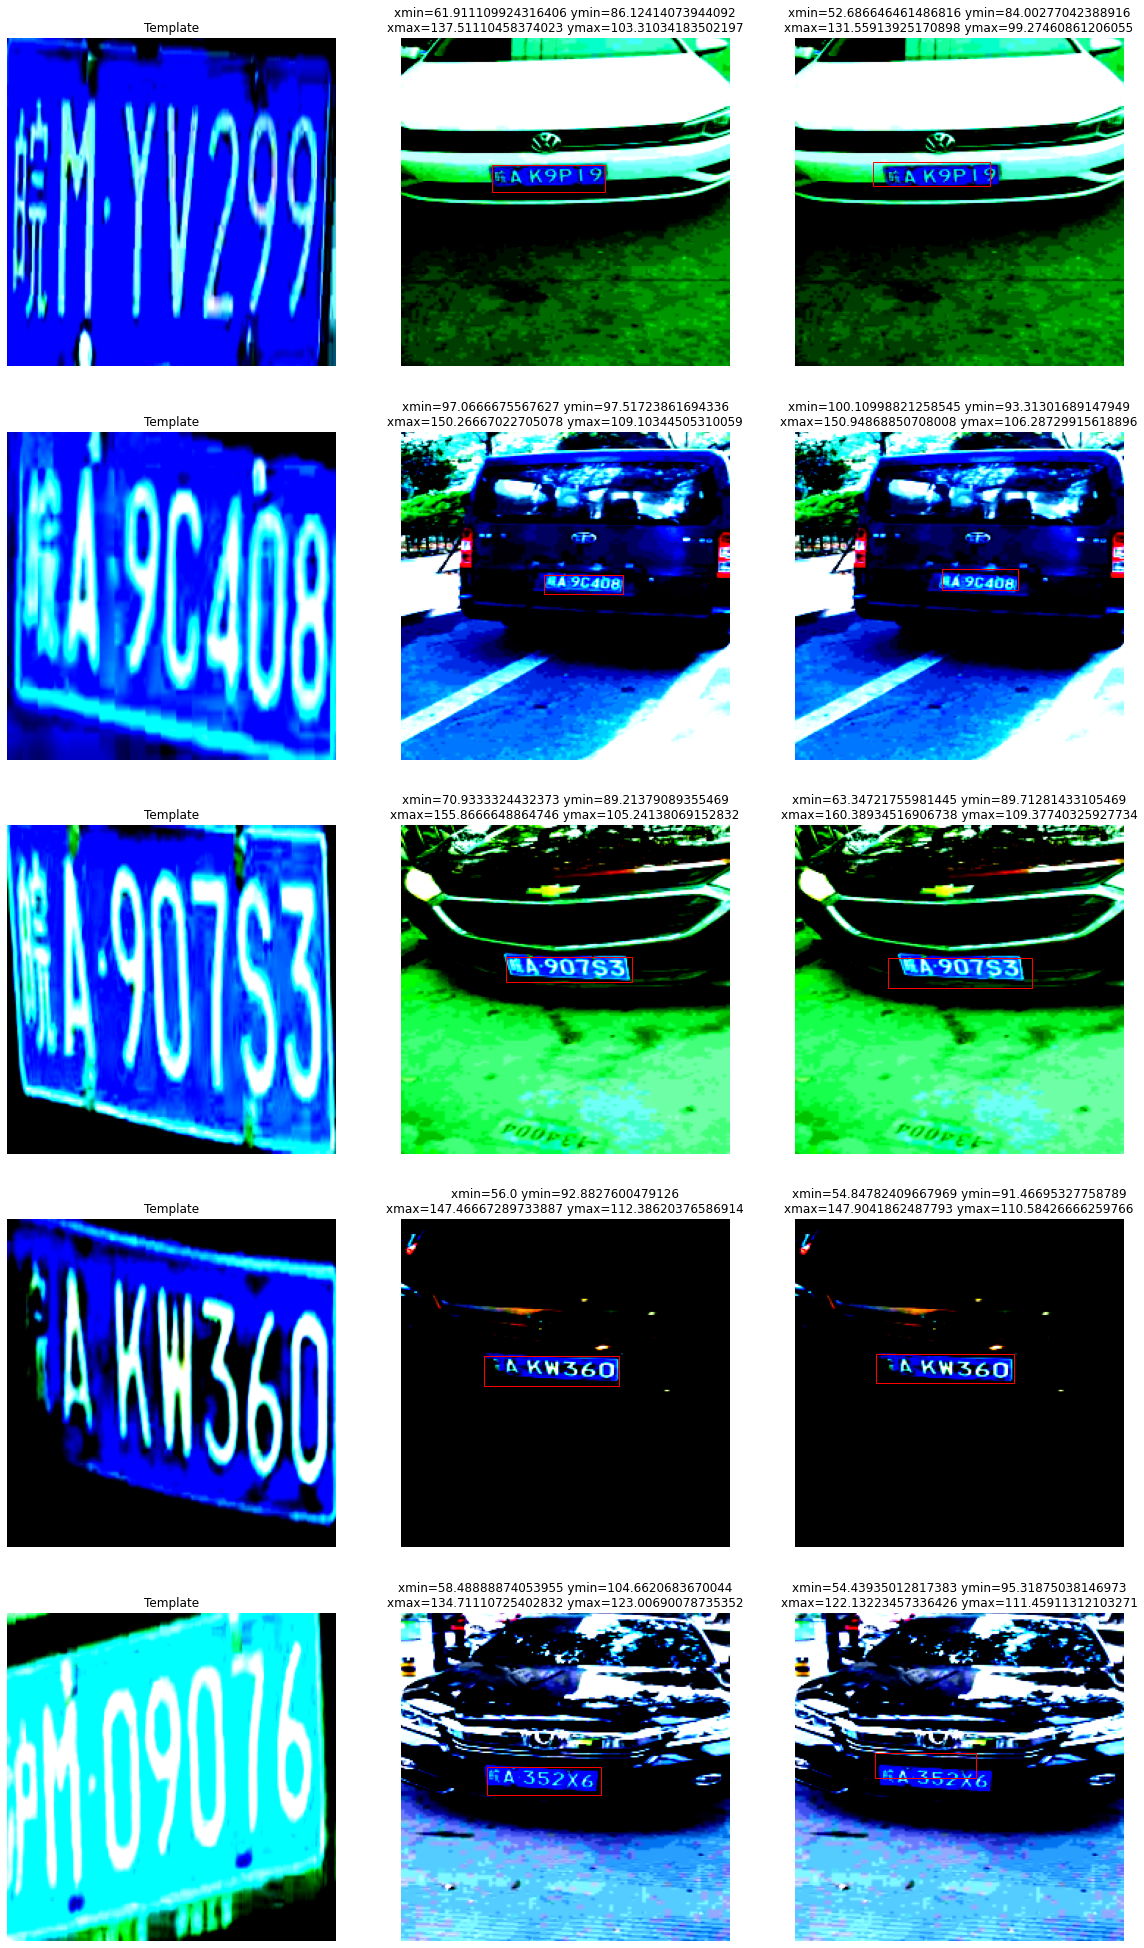

In [17]:
plot_random_samples(train_all_data['images'], train_all_data['templates'], train_all_data['labels'], train_all_data['predictions'])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

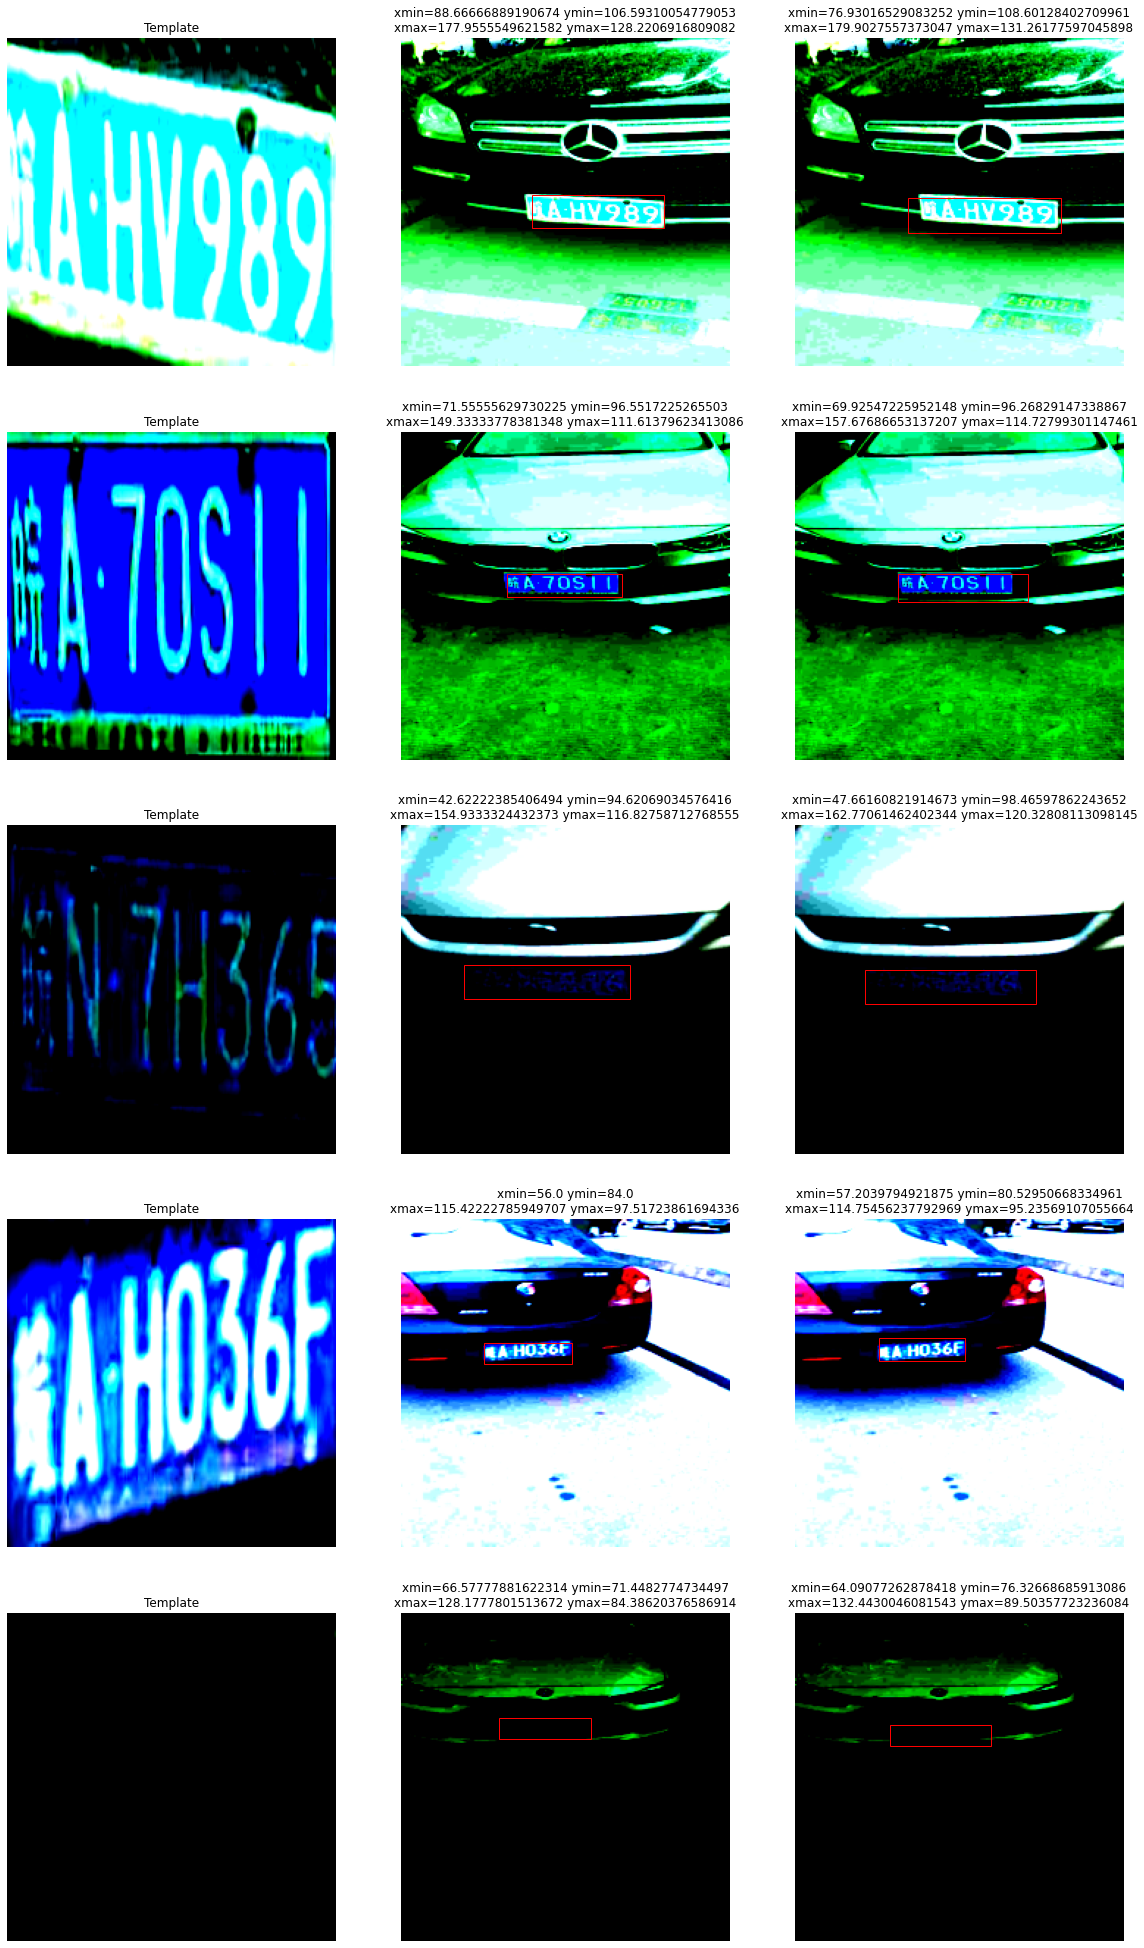

In [19]:
plot_random_samples(val_all_data['images'], val_all_data['templates'], val_all_data['labels'], val_all_data['predictions'], name='validation_results.png')


In [16]:
data_dataframe = pd.DataFrame({
    'epochs': epoch_list,
    'train_loss': train_losses,
    'train_similarities_acc': train_accuracies,
    'train_iou_50%': train_iou[:, 0],
    'train_iou_75%': train_iou[:, 1],
    'train_iou_90%': train_iou[:, 2],
    'val_loss': val_losses,
    'val_similarities_acc': val_accuracies,
    'val_iou_50%': val_iou[:, 0],
    'val_iou_75%': val_iou[:, 1],
    'val_iou_90%': val_iou[:, 2]
})
data_dataframe.to_csv(os.path.join(data_saved_path, "training_data.csv"))
